In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
%%writefile CVRP.py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

class CVRPEnvironment:
    def __init__(self, num_clients=5, num_vehicles=2, max_demand=10, max_capacity=20, map_size=(100, 100)):
        self.num_clients = num_clients
        self.num_vehicles = num_vehicles
        self.max_demand = max_demand
        self.max_capacity = max_capacity
        self.map_size = map_size
        self.reset()

    def reset(self):
        self.depot = np.array([self.map_size[0] // 2, self.map_size[1] // 2])
        self.vehicles = [{
            "position": self.depot.copy(),
            "capacity": self.max_capacity,
            "path": [self.depot.copy()],
            "distance": 0
        } for _ in range(self.num_vehicles)]
        self.clients = [{
            "position": np.random.randint(0, self.map_size[0], size=(1, 2)).squeeze(),
            "demands":random.randint(1, self.max_demand+1)
        } for _ in range(self.num_clients)]
        
        self.visited_clients = []
        return self.get_state()

    def update_mask(self, vehicle_idx):
        """
        Actualiza la máscara considerando la carga del vehículo y las demandas.
        Si no puede atender a ningún cliente, permite regresar al depósito.
        No se visitan los clientes cuya demanda es cero.
        Los vehículos solo pueden ir a clientes cuya demanda sea mayor que cero y que no excedan la carga del vehículo.
        """
        mask = np.zeros(self.num_clients, dtype=bool)  # Por defecto, todos enmascarados
    
        carga = self.vehicles[vehicle_idx]["capacity"]
    
        # Si no hay carga o no hay demanda restante, solo permitimos volver al depósito
        total_demand = sum(client['demands'] for client in self.clients)
        if carga == 0 or total_demand == 0:
            return mask  # Todos los clientes enmascarados, el vehículo debería volver al depósito
    
        # Activamos solo los clientes con demanda válida y alcanzable
        for i, client in enumerate(self.clients):
            if 0 < client['demands'] <= carga:
                mask[i] = True  
    
        # Si no hay clientes alcanzables, permitimos solo ir al depósito
        if not np.any(mask):
            mask[:] = False  # Enmascaramos todos los clientes

        return mask 

    def get_state(self):
        return {
            "clients": self.clients,
            "vehicles": self.vehicles,
            "depot": self.depot
        }

    def step(self, vehicle_idx, client_idx):
        mask = self.update_mask(vehicle_idx)
    
        # Si no hay clientes alcanzables, regresar al depósito
        if not np.any(mask):
            vehicle = self.vehicles[vehicle_idx]
    
            # Si ya está en el depósito, termina su ruta
            if np.array_equal(vehicle["position"], self.depot):
                return self.get_state(), -50, True, mask  # Penalización por inactividad
            
            # Movimiento al depósito
            distance = np.linalg.norm(self.depot - vehicle["position"])
            vehicle["distance"] += distance
            vehicle["position"] = self.depot.copy()
            vehicle["path"].append(self.depot.copy())
            vehicle["capacity"] = self.max_capacity  # Recarga total al regresar

            demands = [cliente['demands'] for cliente in self.clients]
            # Revisamos si quedan clientes pendientes
            for i, demand in enumerate(demands):
                if demand > 0:  # Si hay clientes sin atender
                    for other_idx, other_vehicle in enumerate(self.vehicles):
                        if other_idx != vehicle_idx and demand <= other_vehicle["capacity"]:
                            return self.step(other_idx, i)  # Otro vehículo lo atiende
    
                    # Si nadie más lo atiende, el vehículo recién reabastecido lo hace
                    return self.step(vehicle_idx, i)
            
            return self.get_state(), -distance, True, mask  # Si no quedan clientes, terminamos
    
        # Si el cliente está enmascarado o no tiene suficiente capacidad, penalización
        if not mask[client_idx] or self.clients[client_idx]['demands'] > self.vehicles[vehicle_idx]["capacity"]:
            return self.get_state(), -100, False, mask
    
        # Movimiento al cliente
        vehicle = self.vehicles[vehicle_idx]
        client_pos = self.clients[client_idx]
    
        distance = np.linalg.norm(self.clients[client_idx]['position'] -  self.vehicles[vehicle_idx]["position"])
        self.vehicles[vehicle_idx]["distance"] += distance
        self.vehicles[vehicle_idx]["position"] = client_pos["position"]
        self.vehicles[vehicle_idx]["capacity"] -= self.clients[client_idx]['demands']
        self.vehicles[vehicle_idx]["path"].append(client_pos["position"])
    
        self.visited_clients.append(client_idx)
        self.clients[client_idx]['demands'] = 0 # Cliente atendido
    
        # Comprobar si se han visitado todos los clientes
        done = len(self.visited_clients) == self.num_clients
        reward = -self.vehicles[vehicle_idx]["distance"]  # Penalización por distancia recorrida
        return self.get_state(), reward, done, mask
        
    
    def render(self):
        plt.figure(figsize=(15, 12))
        
        # Dibujamos los clientes
        x_coords, y_coords = zip(*[item['position'] for item in self.clients])
        plt.scatter(x_coords, y_coords, c='blue', label='Clientes')
    
        # Añadimos etiquetas en los puntos de los clientes con su demanda actualizada
        for i, client in enumerate(self.clients):
            demand = client['demands']
            plt.text(client['position'][0] + 1, client['position'][1] + 1, 
                     f'Client{i+1}\nDem: {demand}', fontsize=9, color='black', ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.7))
    
        # Dibujamos el almacén (depósito)
        plt.scatter(self.depot[0], self.depot[1], c='red', marker='s', label='Almacén')
        plt.text(self.depot[0] + 2, self.depot[1] + 2, 'Depósito', fontsize=9, color='red', fontweight='bold')
    
        colors = ['green', 'purple', 'orange', 'brown', 'pink']
        rutas = []  # Lista para almacenar las rutas de cada vehículo con etiquetas
    
        for i, entry in enumerate(self.vehicles):
            path = entry['path']
            path_arr = np.array(path)  
            current_load = entry['capacity'] 
            
            # Convertimos la ruta de coordenadas a etiquetas
            ruta_etiquetada = []
            for pos in path:
                if np.array_equal(pos, self.depot):  # Si es el depósito
                    ruta_etiquetada.append("Depot")
                else:
                    # Buscamos si la posición coincide con algún cliente
                    for j, client in enumerate(self.clients):
                        if np.array_equal(pos, client['position']):
                            ruta_etiquetada.append(f"Client{j+1}")
                            break
    
            # Guardamos la ruta del vehículo en la lista
            rutas.append({'Vehículo': i+1, 'Ruta': ruta_etiquetada, 'Carga Final': current_load})

            # Dibujar la ruta del vehículo
            plt.plot(path_arr[:, 0], path_arr[:, 1], '-o', color=colors[i % len(colors)], label=f'Vehículo {i+1}')
    
            # Dibujar el orden de visita dentro de círculos
            for j, (x, y) in enumerate(path):
                circle = plt.Circle((x, y), radius=2, color='white', ec='black', lw=1.5, zorder=3)
                plt.gca().add_patch(circle)  # Agregar círculo
                plt.text(x, y, str(j), fontsize=9, color='black', fontweight='bold', ha='center', va='center', zorder=4)
    
                # Dibujar distancias entre puntos
                if j < len(path) - 1:
                    x_next, y_next = path[j + 1]
                    distance = np.linalg.norm(np.array([x_next, y_next]) - np.array([x, y]))
                    mid_x, mid_y = (x + x_next) / 2, (y + y_next) / 2
                    plt.text(mid_x, mid_y, f'{distance:.2f}', fontsize=8, color=colors[i % len(colors)], fontweight='bold')
    
            # Etiqueta con el número del vehículo y su carga actualizada en el último punto de la ruta
            plt.text(path_arr[-1, 0] + 3, path_arr[-1, 1] + 3,
                     f'Vehículo {i+1}\nCarga: {current_load}', color=colors[i % len(colors)], fontsize=9, fontweight='bold')
    
        plt.legend()
        plt.title("Rutas de los vehículos con orden, distancias y cargas")
        plt.axis("equal")  # Asegurar proporción correcta en la visualización
        plt.show()
        return rutas
        
    

Overwriting CVRP.py


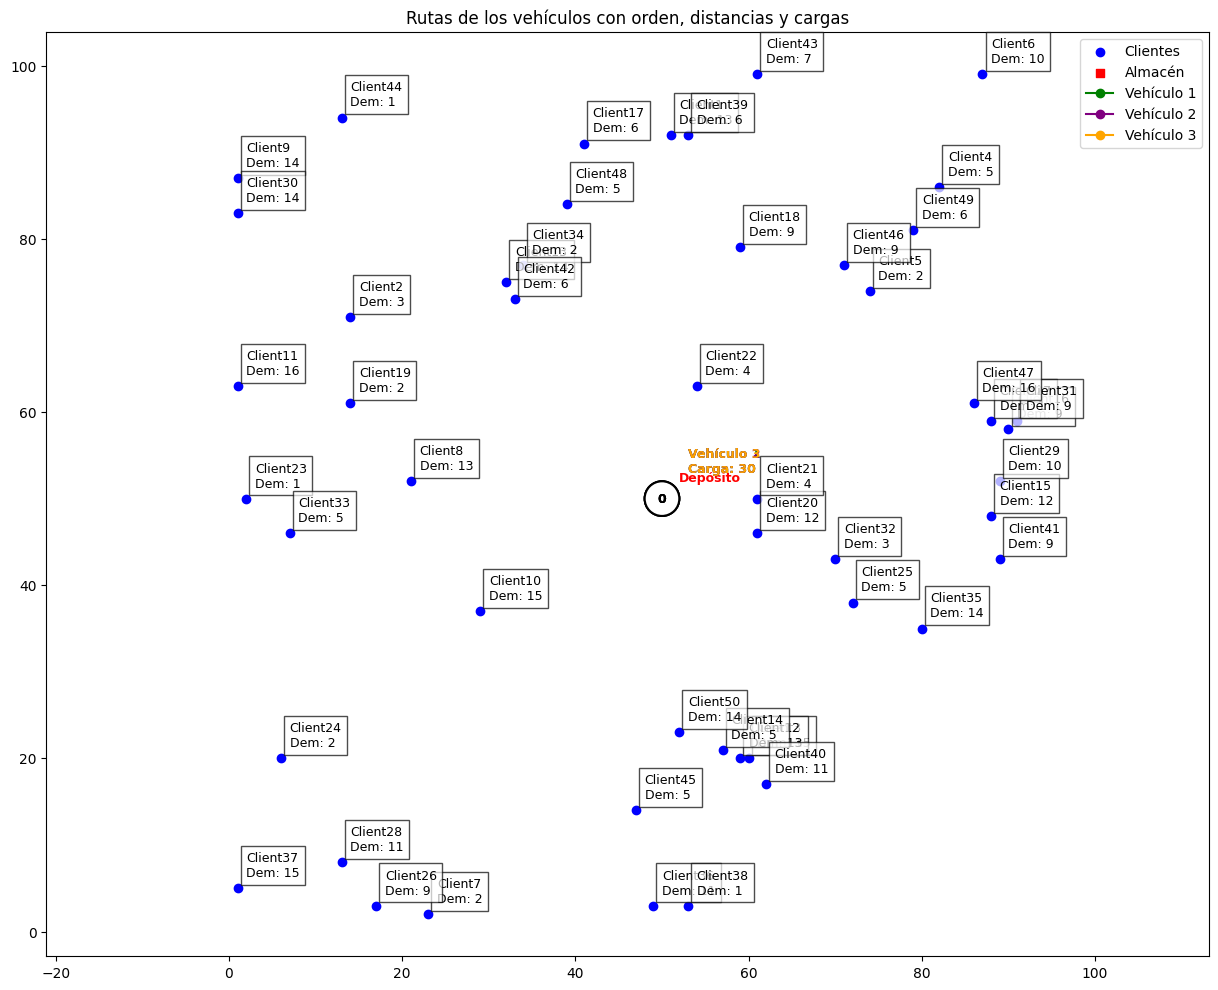

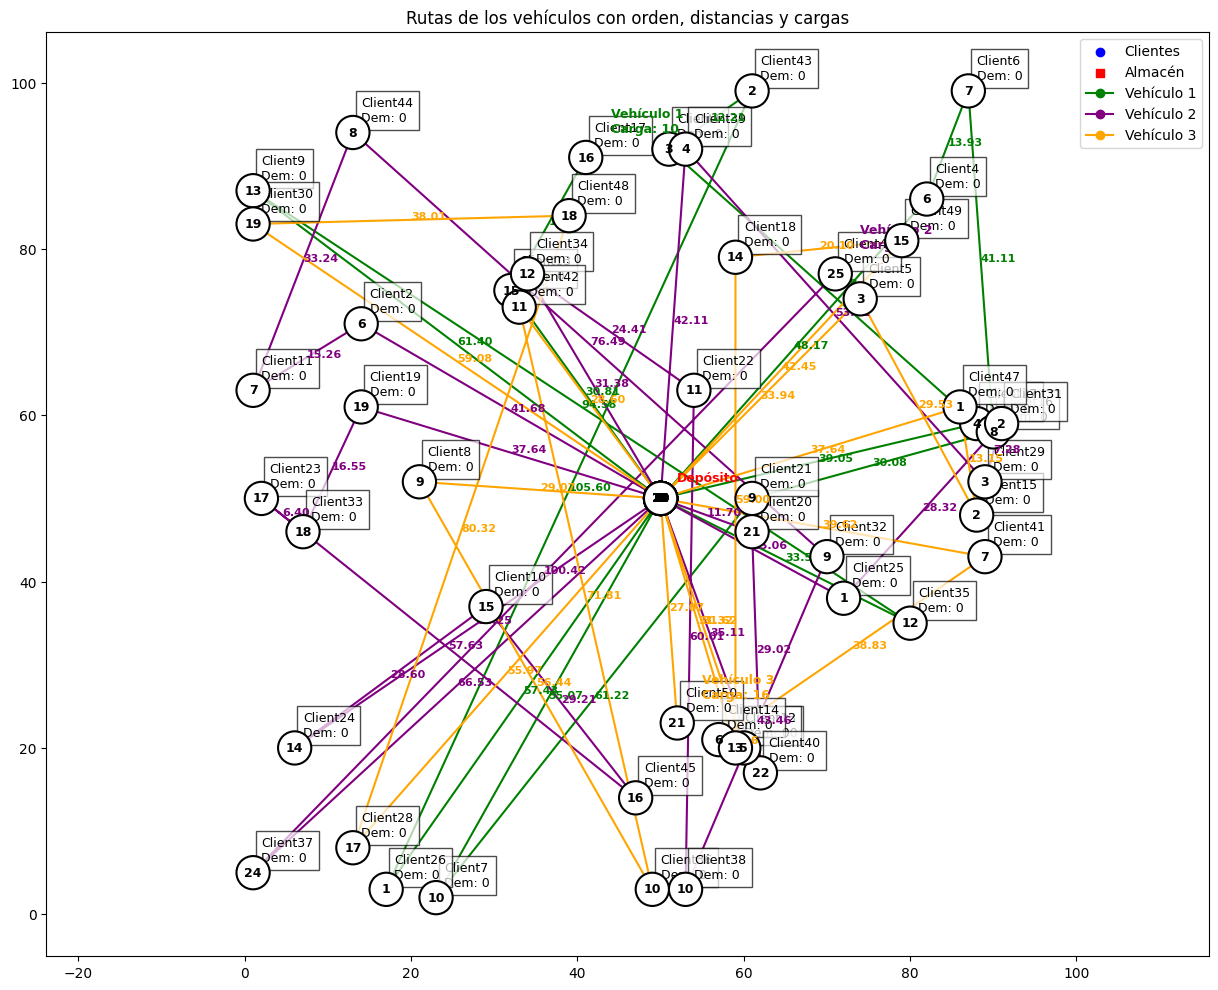

[{'Vehículo': 1,
  'Ruta': ['Depot',
   'Client26',
   'Client43',
   'Client1',
   'Client27',
   'Depot',
   'Client4',
   'Client6',
   'Client16',
   'Client21',
   'Client7',
   'Depot',
   'Client35',
   'Client9',
   'Depot',
   'Client13',
   'Client17'],
  'Carga Final': 10},
 {'Vehículo': 2,
  'Ruta': ['Depot',
   'Client25',
   'Client31',
   'Client29',
   'Client39',
   'Depot',
   'Client2',
   'Client11',
   'Client44',
   'Client32',
   'Client38',
   'Client22',
   'Client34',
   'Depot',
   'Client24',
   'Client10',
   'Client45',
   'Client23',
   'Client33',
   'Client19',
   'Depot',
   'Client20',
   'Client40',
   'Depot',
   'Client37',
   'Client46'],
  'Carga Final': 6},
 {'Vehículo': 3,
  'Ruta': ['Depot',
   'Client47',
   'Client15',
   'Client5',
   'Depot',
   'Client3',
   'Client14',
   'Client41',
   'Depot',
   'Client8',
   'Client36',
   'Client42',
   'Depot',
   'Client12',
   'Client18',
   'Client49',
   'Depot',
   'Client28',
   'Client48',
 

In [9]:
# Ejemplo de uso
from CVRP import CVRPEnvironment
seed=42
np.random.seed(seed)

env = CVRPEnvironment(num_clients=50, num_vehicles=3, max_demand=15, max_capacity=30)
env.render()

done = False
while not done:
    for v in range(env.num_vehicles):
        available_clients = [i for i in range(env.num_clients) if i not in env.visited_clients]
        if not available_clients:
            done = True
            break
        if len(available_clients) > 1:
            client = np.random.choice(available_clients)
        else:
            client = available_clients[0]
        state, reward, done, mask = env.step(v, client)
rutas=env.render()

rutas

### Fuerza bruta

In [10]:
from itertools import permutations
import numpy as np

# Generar todas las permutaciones posibles de los clientes
def fuerza_bruta_cvrp(env):
    clientes = list(range(env.num_clients))
    mejor_ruta = None
    mejor_coste = float('inf')

    # Inicializar las mejores distancias de los vehículos a infinito
    for vehiculo in env.vehicles:
        vehiculo['best_distance'] = float('inf')  # Usamos 'best_distance' para la mejor distancia

    for perm in permutations(clientes):
        rutas = [[] for _ in range(env.num_vehicles)]  # Rutas para cada vehículo
        cargas = [env.vehicles[i]['capacity'] for i in range(env.num_vehicles)]
        idx_vehiculo = 0  # Comenzamos con el primer vehículo

        for cliente in perm:
            demanda = env.clients[cliente]['demands']

            # Si el vehículo no tiene capacidad suficiente, debe volver al depósito
            if cargas[idx_vehiculo] < demanda:
                rutas[idx_vehiculo].append("Depot")  # Retorno al depósito
                cargas[idx_vehiculo] = env.vehicles[idx_vehiculo]['capacity']  # Recarga

                # Asignamos el siguiente vehículo si el actual no tiene más capacidad
                idx_vehiculo = (idx_vehiculo + 1) % env.num_vehicles

            # Asignar cliente al vehículo
            rutas[idx_vehiculo].append(f'Cliente {cliente+1}')  # Etiqueta en lugar de índice
            cargas[idx_vehiculo] -= demanda

        # Cerrar rutas volviendo al depósito
        for i in range(env.num_vehicles):
            if rutas[i] and rutas[i][-1] != "Depot":
                rutas[i].append("Depot")

        # Si todos los clientes han sido asignados, evaluar la ruta
        if sum(len([x for x in r if "Cliente" in x]) for r in rutas) == env.num_clients:
            coste_total = calcular_coste_rutas(env, rutas)
            if coste_total < mejor_coste:
                mejor_coste = coste_total
                mejor_ruta = [["Depot"] + ruta if ruta and ruta[0] != "Depot" else ruta for ruta in rutas]

                # Calcular la distancia de cada vehículo y actualizar su mejor distancia
                for i, ruta in enumerate(rutas):
                    x_prev, y_prev = env.depot
                    distancia_ruta = 0.0
                    for cliente_etiqueta in ruta:
                        if cliente_etiqueta == "Depot":
                            x, y = env.depot
                        else:
                            cliente_idx = int(cliente_etiqueta.split()[-1]) - 1  # Convertir "Cliente X" a índice
                            x, y = env.clients[cliente_idx]['position']
                        distancia_ruta += np.linalg.norm(np.array([x, y]) - np.array([x_prev, y_prev]))
                        x_prev, y_prev = x, y
                    
                    # Actualizamos la mejor distancia para cada vehículo
                    if distancia_ruta < env.vehicles[i]['best_distance']:
                        env.vehicles[i]['best_distance'] = distancia_ruta

    return mejor_ruta, mejor_coste

# Función para calcular la distancia total de una ruta
def calcular_coste_rutas(env, rutas):
    coste_total = 0
    for ruta in rutas:
        if ruta:
            x_prev, y_prev = env.depot
            for cliente_etiqueta in ruta:
                if cliente_etiqueta == "Depot":
                    x, y = env.depot
                else:
                    cliente_idx = int(cliente_etiqueta.split()[-1]) - 1  # Convertir "Cliente X" a índice
                    x, y = env.clients[cliente_idx]['position']
                coste_total += np.linalg.norm(np.array([x, y]) - np.array([x_prev, y_prev]))
                x_prev, y_prev = x, y
    return coste_total

# Ejemplo de uso
env = CVRPEnvironment(num_clients=8, num_vehicles=2, max_demand=15, max_capacity=30)
mejor_ruta, mejor_coste = fuerza_bruta_cvrp(env)
print("Mejor ruta encontrada:", mejor_ruta)
print("Coste total:", mejor_coste)

# Mostrar las mejores distancias encontradas por cada vehículo
best_distances = [vehiculo['best_distance'] for vehiculo in env.vehicles]
print("Mejores distancias encontradas por cada vehículo:", best_distances)


Mejor ruta encontrada: [['Depot', 'Cliente 2', 'Cliente 6', 'Cliente 7', 'Cliente 3', 'Cliente 8', 'Depot'], ['Depot', 'Cliente 1', 'Cliente 4', 'Cliente 5', 'Depot']]
Coste total: 409.03737602769536
Mejores distancias encontradas por cada vehículo: [163.37878762303214, 79.2464510246358]
